In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = './images/train/'
val_dir = './images/validation/'
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28938 images belonging to 7 classes.
Found 7508 images belonging to 7 classes.


In [10]:
from sklearn.utils import class_weight
import numpy as np

labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights_dict = dict(enumerate(class_weights))

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1)
])


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(48, 48, 1)),
    data_augmentation,
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(7, activation='softmax')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1000,
    decay_rate=0.96
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=8, 
    restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopper, checkpoint],
    class_weight=class_weights_dict
)


Epoch 1/100


c:\Users\julia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.1614 - loss: 2.5398 - precision: 0.1714 - recall: 0.0520
Epoch 1: val_accuracy improved from -inf to 0.24267, saving model to best_model.h5.keras
453/453 ━━━━━━━━━━━━━━━━━━━━ 131s 273ms/step - accuracy: 0.1614 - loss: 2.5392 - precision: 0.1714 - recall: 0.0519 - val_accuracy: 0.2427 - val_loss: 1.9729 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.1701 - loss: 2.0010 - precision: 0.1967 - recall: 0.0030
Epoch 2: val_accuracy improved from 0.24267 to 0.25946, saving model to best_model.h5.keras
453/453 ━━━━━━━━━━━━━━━━━━━━ 127s 279ms/step - accuracy: 0.1701 - loss: 2.0010 - precision: 0.1967 - recall: 0.0030 - val_accuracy: 0.2595 - val_loss: 1.8566 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.1845 - loss: 1.9511 - precision: 0.3165 - recall: 0.0021
Epoch 3: val_accuracy improved 

In [13]:
import keras
best_model = tf.keras.models.load_model('best_model.h5.keras')

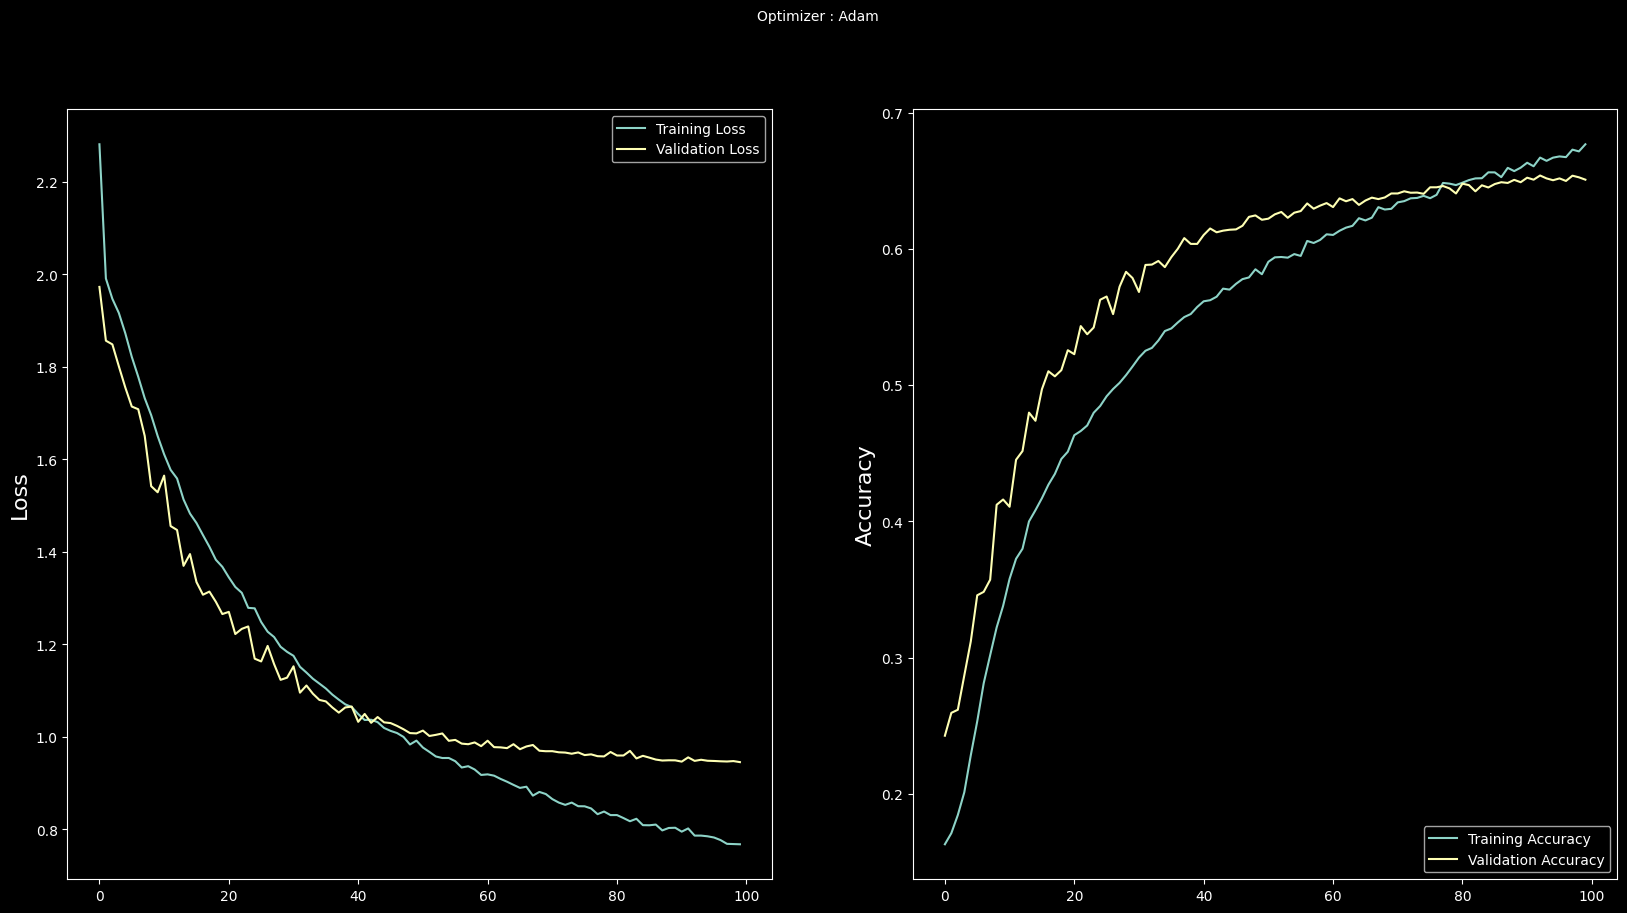

In [14]:
import matplotlib.pyplot as plt
from keras.models import load_model
model = best_model

plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [16]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = validation_generator.classes

report = classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys())
print(report)


118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step
              precision    recall  f1-score   support

       angry       0.13      0.13      0.13       960
     disgust       0.08      0.11      0.09       553
        fear       0.15      0.06      0.09      1018
       happy       0.25      0.22      0.24      1825
     neutral       0.16      0.23      0.19      1216
         sad       0.17      0.15      0.16      1139
    surprise       0.10      0.12      0.11       797

    accuracy                           0.16      7508
   macro avg       0.15      0.15      0.14      7508
weighted avg       0.17      0.16      0.16      7508

